# Prepare

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install --upgrade torch
%pip install --upgrade torchtext
%pip install --upgrade torchvision
%pip install pytorch_lightning
%pip install timm

In [3]:
import sys
import os
module_path = os.path.join(os.path.abspath(''), "drive/MyDrive/Master_Thesis_Profactor/zdmp/")
if module_path not in sys.path:
  sys.path.append(module_path)

import zdmp
import pytorch_lightning
import torch
import torchvision

from torch.utils.data import DataLoader
import numpy as np
import warnings
import timm

# Select Model

In [4]:
model_names = ["luna", "alexnet", "resnet", "efficientnetv2", "convnext", "vit", "swin_t"]
model_name = model_names[1]

In [5]:
# Make the results reproducible
import pytorch_lightning as pl
pl.seed_everything(42)

# Prepare dataset
ds_train, ds_vali = zdmp.get_train_data(vit=(model_names.index(model_name)>=5))
ds_test = zdmp.get_test_data(vit=(model_names.index(model_name)>=5))

# Prepare Dataloaders
dl_train = DataLoader(ds_train, batch_size=32, num_workers=2, shuffle=True)
dl_vali = DataLoader(ds_vali, batch_size=32, num_workers=2)
dl_test = DataLoader(ds_test, batch_size=32, num_workers=2)

Global seed set to 42


zdmp - ViT size - False
get_data - ViT size - False
transform - ViT size - False


In [75]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

# https://github.com/kamata1729/visualize-pytorch/blob/master/main.py

class GradCAM():
    def __init__(self, model, target_layer, use_cuda):
        self.model = model.eval()
        self.target_layer = target_layer
        self.use_cuda = use_cuda
        self.feature_map = 0
        self.grad = 0
        
        if self.use_cuda:
            self.model = self.model.cuda()
        
        for module in self.model.named_modules():
            if module[0] == target_layer:
                module[1].register_forward_hook(self.save_feature_map)
                module[1].register_backward_hook(self.save_grad)
    
    def save_feature_map(self, module, input, output):
        self.feature_map =  output.detach()
        
    def save_grad(self, module, grad_in, grad_out):
        self.grad = grad_out[0].detach()
        
    def __call__(self, x, index=None):
        x = x.clone()
        if self.use_cuda:
            x = x.cuda()
            
        output = self.model(x)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())
            print(index)
            print(output.argmax(dim=1))
            
        one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot)
        one_hot.requires_grad_()
        if self.use_cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        print(one_hot)
            
        self.model.zero_grad()
        
        one_hot.backward()
        
        self.feature_map = self.feature_map.cpu().numpy()[0]
        
        self.weights = np.mean(self.grad.cpu().numpy(), axis = (2, 3))[0, :]
        
        cam = np.sum(self.feature_map * self.weights[:, None, None], axis=0)
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (x.size()[-1], x.size()[-2]))
        return cam, index

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)/255
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [76]:
model_names = ["luna", "alexnet", "resnet", "efficientnetv2", "convnext", "vit", "swin_t"]
model_name = model_names[1]

if model_name == model_names[0]:
    # Luna
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/luna.pth")
    layer = 'block4.conv2'
elif model_name == model_names[1]:
    # AlexNet
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/alexnet.pth")
    layer = 'avgpool'
elif model_name == model_names[2]:
    # ResNet
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/resnet.pth")
    layer = 'layer4.1.conv2'
elif model_name == model_names[3]:
    # EfficientNetV2
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/efficientnetv2.pth")
    layer = 'blocks.5.14.conv_pwl'
    layer = 'blocks.5.14.bn3'
elif model_name == model_names[4]:
    # ConvNeXt
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/convnext_2022_05_13.pth")
    layer = 'features.7.2.block.0'
    layer = 'features.5.8.block.0' # Este esta bueno
    layer = 'features.5.6.block.0'
elif model_name == model_names[5]:
    # ViT
    model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/vit.pth")
    layer = 'blocks.11.attn.qkv'

model.eval()

for module in model.named_modules():
    print(module[0])
    #if module[0] == layer:
    #    print(module)

grad_cam_convnext = GradCAM(model, layer, False)


features
features.0
features.1
features.2
features.3
features.4
features.5
features.6
features.7
features.8
features.9
features.10
features.11
features.12
avgpool
classifier
classifier.0
classifier.1
classifier.2
classifier.3
classifier.4
classifier.5
classifier.6


0
tensor([0])
tensor(5.9806, grad_fn=<SumBackward0>)


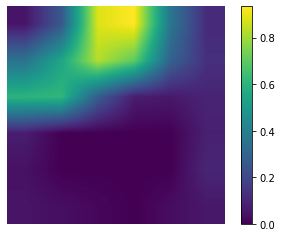

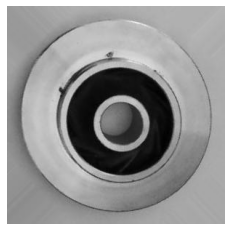

In [77]:
import matplotlib.pyplot as plt

def to_PIL(img, mean=[0.5643], std=[0.2386]):
  trans = torchvision.transforms.ToPILImage()
  img =  img * torch.tensor([std])[:, None, None] + torch.tensor([mean])[:, None, None]
  return trans(img.squeeze())

def norm(img, mean=[0.5643], std=[0.2386]):
  img =  img * torch.tensor([std])[:, None, None] + torch.tensor([mean])[:, None, None]
  return img.squeeze().permute(1,2,0)

img, _ = ds_test[120]


cam, target_index = grad_cam_convnext(img.unsqueeze(0))

plt.imshow(cam)
plt.colorbar()
plt.axis('off')
plt.show()

plt.imshow(to_PIL(img))
plt.axis('off')
plt.show()

In [ ]:
in_features = 1
out_features = 10

linear = torch.nn.Linear(in_features, out_features)

inp = torch.rand(1, 2, 3, 4, in_features)
output = linear(inp)

print(output.shape)

torch.Size([1, 2, 3, 4, 10])


# VGG

In [ ]:
vgg = torchvision.models.vgg19()

from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

#torchvision.models.feature_extraction.get_graph_node_names(vgg)

return_nodes = {'features.35': 'features.35'}

body = create_feature_extractor(vgg, return_nodes=return_nodes)


img = ds_test[0]

out = body(img[0].unsqueeze(0))

print(out['features.35'].shape)

torch.Size([1, 512, 18, 18])


In [253]:
a = torch.tensor([2., 0, 0, 2, 1, 0, 0, 2, 1, 1, 0, 0, 1, 1, 1], requires_grad=True)


def group_by_index(a):
    b = a.unsqueeze(-2)
    c = b.mT @ b
    x = torch.tril(torch.ones_like(c), -1) + torch.triu(c)
    tmp = (x == 0).cumsum(axis=-1)
    x[tmp>0] = 0
    x, _ = torch.max(x, dim=-2)
    x[x<2] = 0
    x[x>1] = 1
    
    vals = (a==2).cumsum(axis=-1)
    return x * vals


x = group_by_index(a)
print(x)

tensor([1., 0., 0., 2., 2., 0., 0., 3., 3., 3., 0., 0., 0., 0., 0.],
       grad_fn=<MulBackward0>)


In [263]:
a=b=c = torch.randn(6, 3, 10)
list_ = [a,b,c]

out = torch.zeros(6, 3, 3, 10)
print(list_[0].shape)
print(torch.cat(list_, dim=1, out=out).shape)

torch.Size([6, 3, 10])
torch.Size([6, 9, 10])


# CAPTUM

In [ ]:
!pip install captum
from captum.attr import GuidedGradCam, IntegratedGradients, LayerGradCam

In [8]:
img, _ = ds_test[120]

x = img.unsqueeze(0)
x.requires_grad_(True)

tensor([[[[ 0.1665,  0.1665,  0.1665,  ...,  0.6102,  0.6102,  0.6102],
          [ 0.1665,  0.1665,  0.1665,  ...,  0.6102,  0.6102,  0.6102],
          [ 0.1665,  0.1665,  0.1665,  ...,  0.6102,  0.6102,  0.6102],
          ...,
          [ 0.0021, -0.0143, -0.0143,  ...,  0.3473,  0.3473,  0.3473],
          [ 0.0021, -0.0143, -0.0143,  ...,  0.3473,  0.3473,  0.3473],
          [ 0.0021, -0.0143, -0.0143,  ...,  0.3473,  0.3473,  0.3473]],

         [[ 0.1665,  0.1665,  0.1665,  ...,  0.6102,  0.6102,  0.6102],
          [ 0.1665,  0.1665,  0.1665,  ...,  0.6102,  0.6102,  0.6102],
          [ 0.1665,  0.1665,  0.1665,  ...,  0.6102,  0.6102,  0.6102],
          ...,
          [ 0.0021, -0.0143, -0.0143,  ...,  0.3473,  0.3473,  0.3473],
          [ 0.0021, -0.0143, -0.0143,  ...,  0.3473,  0.3473,  0.3473],
          [ 0.0021, -0.0143, -0.0143,  ...,  0.3473,  0.3473,  0.3473]],

         [[ 0.1665,  0.1665,  0.1665,  ...,  0.6102,  0.6102,  0.6102],
          [ 0.1665,  0.1665,  

In [56]:
model = torch.load("/content/drive/MyDrive/Master_Thesis_Profactor/zdmp/pretrained_weights/models/resnet.pth")
layer = 'layer4.1.conv2'

layer_gc = LayerGradCam(model, model.layer4[1].conv2)
attribution = layer_gc.attribute(x, 0)

#attr_alg = IntegratedGradients(model)
#attributions = attr_alg.attribute(x, target=0)

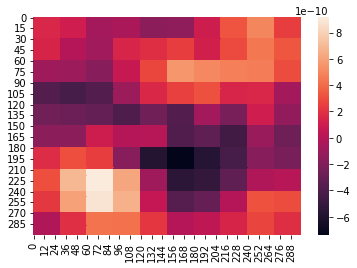

In [73]:
from captum.attr import LayerAttribution


at = LayerAttribution.interpolate(attribution, (300, 300))

sns.heatmap(at[0][0].detach())

In [61]:
att = (attributions + torch.abs(torch.min(attributions)))
att = att / torch.abs(torch.max(att))

In [50]:
torch.max(att)

tensor(1., dtype=torch.float64, grad_fn=<MaxBackward1>)

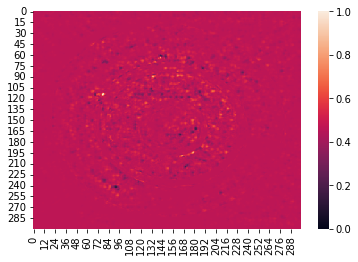

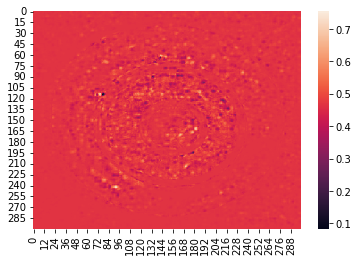

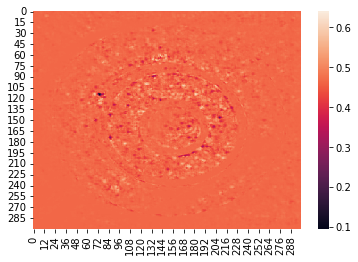

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns


#plt.imshow(att[0].permute(1, 2, 0).detach().numpy())
sns.heatmap(att[0][0].detach().numpy())
plt.show()
sns.heatmap(att[0][1].detach().numpy())
plt.show()
sns.heatmap(att[0][2].detach().numpy())
plt.show()

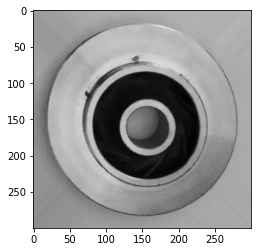

In [54]:
plt.imshow(img.permute(1, 2, 0) * 0.2386 + 0.5643)